# Processing of FragPipe results with MsReport

## Library imports and notebook settings
- Created with MsReport version 0.0.13

In [1]:
from IPython.display import display
import os

import msreport.helper
import msreport_scripts.excel_report
from msreport.rinterface import r_package_version

In [2]:
print(f"MsReport version: {msreport.__version__}")
print(f"LIMMA version:", r_package_version("LIMMA"))

MsReport version: 0.0.13
LIMMA version: 3.54.2


In [3]:
msreport.plot.set_dpi(90)

## Parameters

In [4]:
# General settings
special_proteins = ["P38182", "P40344", "P38862", "3OGO"]
expression_tag = "Intensity"
batch_correction = False  # To use LIMMA with batch correction, set this variable to True and add a "Batch" column to the design

# Protein validation parameters
min_peptides = 2
min_quantified_values = 2

# Imputation parameters
imputation_parameters = {"column_wise": True, "seed": 64}

# Define input and output paths
search_dir = "../ms_data/GFP-Atg8_trypsin_untreated"
fasta_path = [
    "../database/2022.01_UP000002311_559292_Saccaromyces_cerevisiae_1protein_per_gene.fasta",
    "../database/gfp_nanobody_contaminants_with_tag.fasta"
]
output_dir = "../qtable_data"
output_basename = "GFP-Atg8_trypsin_untreated"

In [5]:
# Generate default output names
excel_report_filepath = os.path.join(output_dir, "_".join([output_basename, "protein_report.xlsx"]))
amica_table_filename = "_".join([output_basename, "amica_table.tsv"])
amica_design_filename = "_".join([output_basename, "amica_design.tsv"])

## Import and process data

### Import search results and protein database

In [6]:
reader = msreport.FragPipeReader(search_dir)
protein_table = reader.import_proteins()
peptide_table = reader.import_peptides()

design = msreport.helper.guess_design(protein_table, tag="Intensity")
design["Experiment"] = ["GFP_Atg8"]
display(design.T)

protein_db = msreport.import_protein_database(fasta_path)

,0
Sample,GFP_Atg8
Experiment,GFP_Atg8
Replicate,Atg8


### Add additional annotations to the protein table

In [7]:
msreport.reader.add_protein_annotation(
    protein_table,
    protein_db,
    gene_name=True,
    protein_name=True,
    protein_length=True,
    molecular_weight=True,
    fasta_header=True,
    ibaq_peptides=True,
)
msreport.reader.add_ibaq_intensities(protein_table, normalize=True)
msreport.reader.propagate_representative_protein(peptide_table, protein_table)
msreport.reader.add_peptide_positions(peptide_table, protein_db)
msreport.reader.add_sequence_coverage(protein_table, peptide_table)

### Create a qtable, set expression values and validate data

In [8]:
qtable = msreport.Qtable(protein_table, design=design)
qtable.set_expression_by_tag(expression_tag, log2=True)

msreport.analyze.analyze_missingness(qtable)
msreport.analyze.validate_proteins(qtable, min_peptides=min_peptides, min_events=min_quantified_values)

## Quality control

### Contaminants

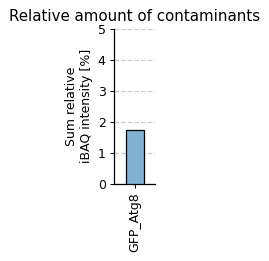

In [9]:
fig, axes = msreport.plot.contaminants(qtable)

## Export data

In [10]:
qtable.save(output_dir, output_basename)

In [11]:
msreport_scripts.excel_report.write_protein_report(
    qtable.data,
    qtable.design,
    excel_report_filepath,
    special_proteins=special_proteins,
    sort_by="Spectral count Combined",
)